In [1]:
from matplotlib import pyplot as plt
import latexify
import numpy as np
import random
import math

In [2]:
'''Parámetros de entrada
'''
ppl_size = 100 #int(input("Tamaño de la población: "))
generations = 7000 #int(input("Número de generaciones: "))
p_crossover = 1.0 #float(input("Porcentaje de cruza: "))
p_mutation = 0.5 #float(input("Porcentaje de mutación: "))

## Code

### Binary representation

In [12]:
def generateBinarySolution(case):
    if (case == 1):
        return np.random.randint(2, size=10*15)
    if (case == 2):
        return np.random.randint(2, size=10*14)

def deterministicSampling(population, apptitudes):
    integers = []
    decimals = []
    net_fit = np.array(apptitudes).sum(axis=0)[1]
    for fit_i in apptitudes:
        expected = (fit_i[1]/net_fit)*len(population)
        i, d = divmod(expected, 1)
        decimals.append((fit_i[0],d))
        if (i == 1.0):
            integers.append(fit_i[0])
    decimals = sorted(decimals,key=lambda l:l[1], reverse=True)
    index_1 = integers[0]
    index_2 = decimals[0][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

def binaryCrossover(solution1, solution2):    
    cross_pt = random.randint(1, solution1.size-1)
    first_half1  = solution1[:cross_pt]
    second_half1 = solution1[cross_pt:]
    first_half2  = solution2[:cross_pt]
    second_half2 = solution2[cross_pt:]
    sol_1 = np.concatenate((first_half1,second_half2))
    sol_2 = np.concatenate((first_half2,second_half1))
    return sol_1, sol_2

def binaryMutation(solution):
    index = random.randint(1, solution.size-1)
    if (solution[index] == 0):
        solution[index] = 1
    else:
        solution[index] = 0
    return solution

### Real Representation

In [13]:
def generateRealSolution(case):
    if (case == 1):
        return np.random.uniform(-10,10,10)
    if (case == 2):
        return np.random.uniform(-5.12,5.12,10)

def deterministicTournament(population, apptitudes):
    indx_lst = random.sample(range(0, ppl_size), 4)
    parents_subset = []
    for indx in indx_lst:
        parents_subset.append(apptitudes[indx])
    parents_subset.sort(key=lambda a: a[1])
    index_1 = parents_subset[0][0]
    index_2 = parents_subset[1][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

def realCrossover(good_solution,bad_solution,alpha,beta):
    H = []
    k = len(good_solution)
    for i in range(0, k):
        I = abs(good_solution[i] - bad_solution[i])
        if (good_solution[i] < bad_solution[i]):
            Li = good_solution[i] - alpha*I
            Ls = bad_solution[i] + beta*I
        else:
            Li = bad_solution[i] - beta*I
            Ls = good_solution[i] + alpha*I
        h_i = np.random.uniform(Li,Ls)
        H.append(h_i)
    return np.array(H)

def realMutation(solution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    index = random.randint(1, solution.size-1)
    solution[index] = np.random.uniform(Linf,Lsup,1)[0]
    return solution

### Common

In [14]:
def decodeBin2Real(binSolution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    split_indx = 0
    d_splits = np.split(binSolution, 10)
    RealSolution = []
    while (split_indx < 10):
        local_indx = 0
        x_integer = 0
        x = d_splits[split_indx]
        while (local_indx<L):
            if (x[local_indx] ==1):
                x_integer += local_indx**2
            local_indx += 1
        x_real = Linf + (x_integer*(Lsup - Linf))/(2**L - 1)
        RealSolution.append(x_real)
        split_indx += 1
    return np.array(RealSolution)

def fitness(x, case, isBin = False):
    if (isBin == True):
        x = decodeBin2Real(x,case)  
    if (case == 1):
        return np.sum(x**2)
    if (case == 2):
        return 10*10 + np.sum(x**2 - 10*np.cos(2*np.pi*x))    

def generatePopulation(size, case, isBin):
    population = []
    apptitudes = []
    for index in range (0,size):
        if (isBin == True):
            solution = generateBinarySolution(case)
        else:
            solution = generateRealSolution(case)
        apptitude = fitness(solution,case,isBin)
        apptitudes.append((index,apptitude))
        population.append(solution)
    return population, apptitudes

## Execution

### Binary representation

In [6]:
def executeBinaryRepresentation(c):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    flag = False
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=True)

    for count in range(generations):
        parent_1, parent_2 = deterministicSampling(population, apptitudes)

        pc = np.random.uniform(0,1,1)[0]
        if (pc <= p_crossover):
            son_1, son_2 = binaryCrossover(parent_1, parent_2)
        else:
            son_1, son_2 = parent_1, parent_2

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = binaryMutation(son_1)
            son_2 = binaryMutation(son_2)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=True)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=True)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
    return bestApptitude, averageApptitude

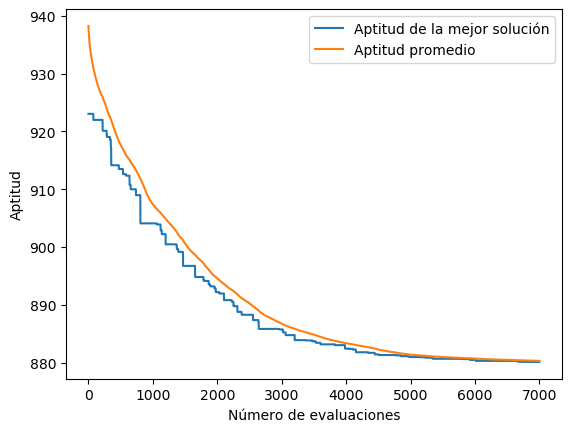

In [7]:
bbest_appt_1, avg_appt_1 = executeBinaryRepresentation(1)

plt.plot(bbest_appt_1, label='Aptitud de la mejor solución')
plt.plot(avg_appt_1, label='Aptitud promedio')

plt.xlabel("Número de evaluaciones")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

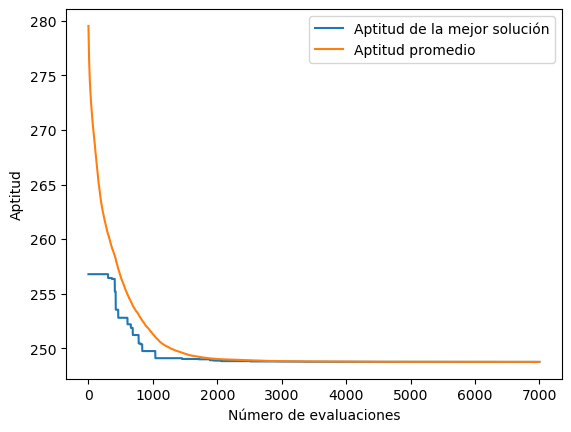

In [8]:
bbest_appt_2, avg_appt_2 = executeBinaryRepresentation(2)

plt.plot(bbest_appt_2, label='Aptitud de la mejor solución')
plt.plot(avg_appt_2, label='Aptitud promedio')

plt.xlabel("Número de evaluaciones")
plt.ylabel("Aptitud")
plt.legend() 
plt.show() 

### Real representation

In [9]:
def executeRealRepresentation(c):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    flag = False
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)

    for count in range(generations):
        parent_1, parent_2 = deterministicTournament(population, apptitudes)
        fit_1 = fitness(parent_1,case=c,isBin=False)
        fit_2 = fitness(parent_2,case=c,isBin=False)
        if (fit_1 < fit_2):
            son_1 = realCrossover(parent_1, parent_2, 0.5, 0.5)
            son_2 = realCrossover(parent_1, parent_2, 0.5, 0.5)
        else: 
            son_1 = realCrossover(parent_2, parent_1, 0.5, 0.5)
            son_2 = realCrossover(parent_2, parent_1, 0.5, 0.5)

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = realMutation(son_1,c)
            son_2 = realMutation(son_2,c)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
    return bestApptitude, averageApptitude

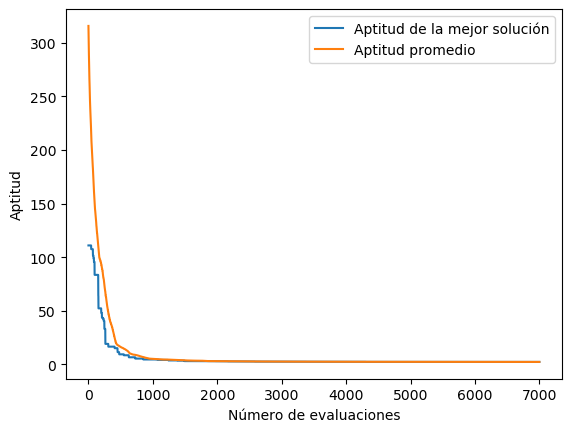

In [10]:
bbest_appt_3, avg_appt_3 = executeRealRepresentation(1)

plt.plot(bbest_appt_3, label='Aptitud de la mejor solución')
plt.plot(avg_appt_3, label='Aptitud promedio')

plt.xlabel("Número de evaluaciones")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

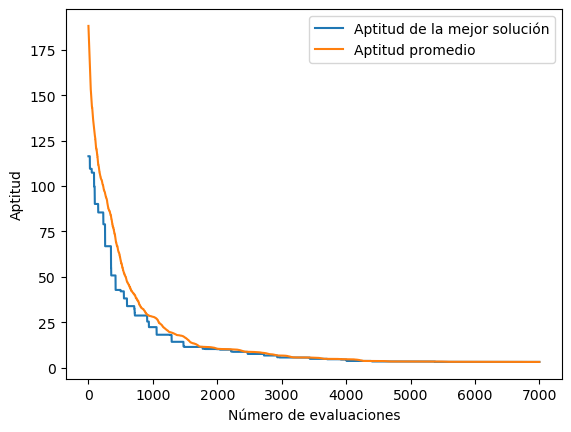

In [11]:
bbest_appt_4, avg_appt_4 = executeRealRepresentation(2)

plt.plot(bbest_appt_4, label='Aptitud de la mejor solución')
plt.plot(avg_appt_4, label='Aptitud promedio')

plt.xlabel("Número de evaluaciones")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()